<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/transferlearning/DUDL_transfer_codeChallenge_letters2numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import the data

In [3]:
# Download the datasets
letter_data = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)
number_data = torchvision.datasets.EMNIST(root='emnist', split='digits', download=True)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


In [6]:
# TRANSFORMATIONS ON THE LETTER DATA

# Remove N/A class
letter_categories = letter_data.classes[1:]
labels            = copy.deepcopy(letter_data.targets) - 1

# Transform to 4D tensor for conv layer (and transform from int8 to float)
letter_images = letter_data.data.view([letter_data.data.shape[0], 1, 28, 28]).float()
# Normalize the letter_images
letter_images /= torch.max(letter_images)

# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(letter_images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data,  test_labels)

# Translate into Dataloader objects
batch_size   = 32
letter_train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
letter_test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

In [8]:
# TRANSFORMATIONS ON THE NUMBERS DATA

# Transform to 4D tensor for conv layer (and transform from int8 to float)
number_images = number_data.data.view([number_data.data.shape[0], 1, 28, 28]).float()
# Normalize the number_images
number_images /= torch.max(number_images)

# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(number_images, number_data.targets, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data,  test_labels)

# Translate into Dataloader objects
batch_size   = 32
number_train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
number_test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

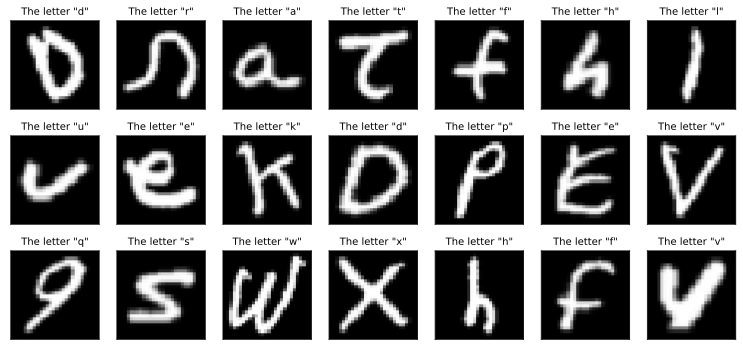

In [9]:
# visualize some letters
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of letter data
X,y = next(iter(letter_train_loader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  letter = letter_categories[y[i]]
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The letter "%s"'%letter,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()


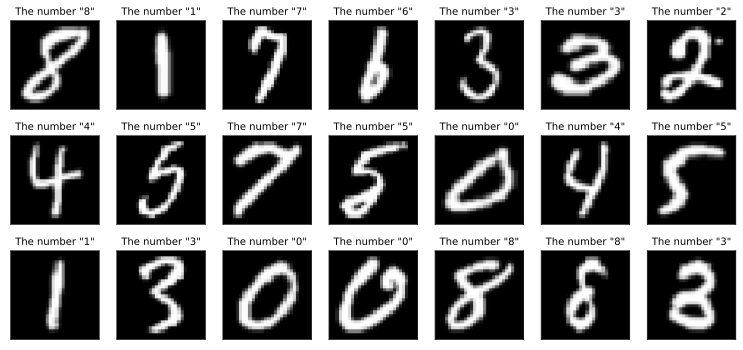

In [10]:
# visualize some numbers
fig,axs = plt.subplots(3,7,figsize=(13,6))

# get a batch of number data
X,y = next(iter(number_train_loader))

for i,ax in enumerate(axs.flatten()):
  
  # extract the image and its target letter
  I = np.squeeze( X[i,:,:] )
  number = y[i].item()
  
  # visualize
  ax.imshow(I.T,cmap='gray',vmin=0,vmax=1)
  ax.set_title('The number "%s"'%number,fontsize=10)
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Create the DL model

In [11]:
def make_the_net(print_toggle=False):
    """
    CNN_EMNIST, TRANSFER_LETTER2NUMBER
    """
    class emnist_net(nn.Module):
        def __init__(self, print_toggle):
            super().__init__()

            self.print = print_toggle

            ######################## FEATURE MAP LAYERS ########################
            self.conv1  = nn.Conv2d(1, 6, kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=6)
                # (28 + 2*1 - 3)/1 + 1 = 28/2 = 14
            
            self.conv2  = nn.Conv2d(6, 6, kernel_size=3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(num_features=6)
                # (14 + 2*1 - 3)/1 + 1 = 14/2 = 7

            ######################## LINEAR DECISION LAYERS ####################
            self.fc1 = nn.Linear(7 * 7 * 6, 50)
            self.fc2 = nn.Linear(50, 26)
        
        def forward(self, x):
            # Convolution -> Maxpool -> Batchnorm -> Relu
            if self.print:    print(f'Input:            {list(x.shape)}')

            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print:    print(f'First CPR Block:  {list(x.shape)}')

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print:    print(f'Second CPR Block: {list(x.shape)}')

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x       = x.view(-1, int(n_units))
            if self.print:    print(f'Vectorized:       {list(x.shape)}')

            # Linear layer
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)
            if self.print:    print(f'Final output:     {list(x.shape)}')

            return x
    
    # Create the model instance
    net = emnist_net(print_toggle)

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_func, optimizer

# Create a function that trains the model

In [12]:
def train_the_model(net, optimizer, train_loader, test_loader, num_epochs=10):
    """
    TRANSFER_LETTER2NUMBER
    """
    
    num_epochs = 10

    # Create a new model
    net, loss_func, optimizer = make_the_net()

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_err  = torch.zeros(num_epochs)
    test_err   = torch.zeros(num_epochs)

    # Send the model to the GPU
    net.to(device)

    # Loop over epochs
    for epoch_i in range(num_epochs):
        net.train()

        # Loop over training data batches
        batch_err  = []
        batch_loss = [] 

        for X, y in train_loader:

            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Error from this batch
            batch_loss.append(loss.item())
            batch_err .append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_err [epoch_i] = 100 * np.mean(batch_err)

        # Test accuracy
        net.eval()
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_err     [epoch_i] = 100 * torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item()

    # End epochs

    return train_loss, test_loss, train_err, test_err, net

# Train the model on the letters

In [14]:
letter_net, loss_func, optimizer = make_the_net()
train_loss, test_loss, train_err, test_err, letter_net = train_the_model(net=letter_net, optimizer=optimizer, train_loader=letter_train_loader, test_loader=letter_test_loader, num_epochs=5)

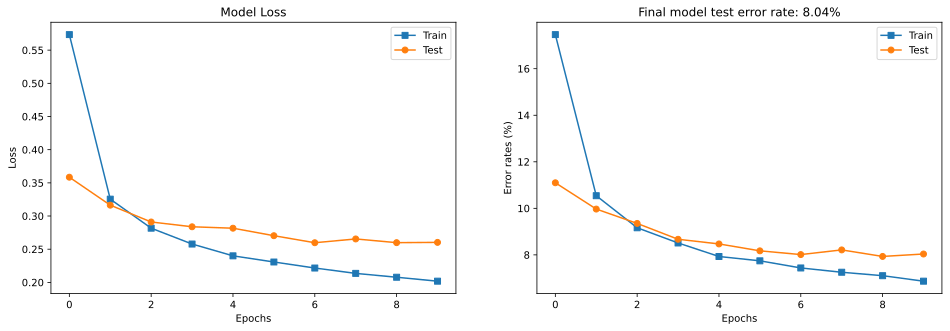

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_err, 's-', label='Train')
ax[1].plot(test_err,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {test_err[-1]:.2f}%')
ax[1].legend()

plt.show()

# Test the model on the number data

In [16]:
## TEST THE MODEL ON THE NUMBER DATA
# Extract X, y from NUMBER test dataloader
X, y = next(iter(number_test_loader))
X    = X.to(device)
y    = y.to(device)

letter_net.eval()
y_hat = letter_net(X)

# Test
number_acc = 100 * torch.mean((torch.argmax(y_hat, axis=1) != y).float())
print(f'number_net error rate on NUMBER data: {number_acc:.2f}%')

number_net error rate on NUMBER data: 93.85%


# Fine-tune the model with one training batch

In [17]:
## Fine-tune the model with one training batch
# Create the target model
number_net, loss_func, optimizer = make_the_net()

# Replace all the weights in TARGET model from SOURCE model
for target, source in zip(number_net.named_parameters(), letter_net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

In [18]:
# Check out the network
print(number_net, '\n')
# The final layer
print(number_net.fc2, '\n')

# Replace the final layer to have 10 outputs instead of 26
number_net.fc2 = nn.Linear(50, 10)
# Check again
print(number_net)

emnist_net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=26, bias=True)
) 

Linear(in_features=50, out_features=26, bias=True) 

emnist_net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bnorm2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=294, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


In [19]:
## Re-train the network on the numbers data
train_loss, test_loss, train_err, test_err, number_net = train_the_model(net=number_net, optimizer=optimizer, train_loader=number_train_loader, test_loader=number_test_loader, num_epochs=1)

In [20]:
print(f'number_net TRAIN error rate: {train_err[-1]:.2f}%')
print(f'number_net TEST  error rate: {test_err [-1]:.2f}%')

number_net TRAIN error rate: 0.44%
number_net TEST  error rate: 0.70%


# Try again, only train output layer

In [22]:
## Try again, only train the output layer
# Create the target model
number_net_2, loss_func, optimizer = make_the_net()

# Replace all the weights in TARGET model from SOURCE model
for target, source in zip(number_net_2.named_parameters(), letter_net.named_parameters()):
    target[1].data = copy.deepcopy(source[1].data)

# Replace the final layer to have 10 outputs instead of 26
number_net_2.fc2 = nn.Linear(50, 10)

# Freeze all layers except output
for p in number_net_2.named_parameters():
    if (not 'fc2' in p[0]):
        p[1].requires_grad = False

In [26]:
## Re-train the network on the numbers data
train_loss, test_loss, train_err, test_err, number_net_2 = train_the_model(net=number_net_2, optimizer=optimizer, train_loader=number_train_loader, test_loader=number_test_loader, num_epochs=1)

print(f'number_net TRAIN error rate: {train_err[-1]:.2f}%')
print(f'number_net TEST  error rate: {test_err [-1]:.2f}%')

number_net TRAIN error rate: 0.47%
number_net TEST  error rate: 0.88%
